<a href="https://colab.research.google.com/github/ZeyuSun/thor/blob/main/pathway_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install/Upgrade packages
!pip install venn
!pip install networkx
!pip install ipdb

  Created wheel for venn: filename=venn-0.1.3-cp36-none-any.whl size=19703 sha256=f8baf658590bbf62d72af91dff8565c2d2016d4917561bd785fd7b41eb6641e0
  Stored in directory: /root/.cache/pip/wheels/41/e4/83/4269e8fb3c81b09363ebe355c373b14b0b947394d2af541734
Successfully built venn
  Created wheel for ipdb: filename=ipdb-0.13.4-cp36-none-any.whl size=10973 sha256=89ec9368d02b56eec0f9c460145a23484cd3bb7fd0aee937eef42f18d601795c
  Stored in directory: /root/.cache/pip/wheels/56/51/e4/c91c61e3481a1a967beb18c4ea7a2b138a63cce94170b2e206
Successfully built ipdb


In [2]:
import os
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, binom
from scipy import special
from scipy import sparse
plt.rcParams['image.cmap']='RdBu'
import networkx as nx

In [3]:
# Modifying venn function
from functools import partial
from venn import draw_venn
from matplotlib.colors import to_rgba
from matplotlib.cm import ScalarMappable

def generate_logics(n_sets):
    """Generate intersection identifiers in binary (0010 etc)"""
    for i in range(1, 2**n_sets):
        yield bin(i)[2:].zfill(n_sets)

def is_valid_dataset_dict(data):
    """Validate passed data (must be dictionary of sets)"""
    if not (hasattr(data, "keys") and hasattr(data, "values")):
        return False
    for dataset in data.values():
        if not isinstance(dataset, set):
            return False
    else:
        return True

def generate_colors(cmap="viridis", n_colors=6, alpha=.4):
    """Generate colors from matplotlib colormap; pass list to use exact colors"""
    if not isinstance(n_colors, int) or (n_colors < 2) or (n_colors > 6):
        raise ValueError("n_colors must be an integer between 2 and 6")
    if isinstance(cmap, list):
        colors = [to_rgba(color, alpha=alpha) for color in cmap]
    else:
        scalar_mappable = ScalarMappable(cmap=cmap)
        colors = scalar_mappable.to_rgba(range(n_colors), alpha=alpha).tolist()
    return colors[:n_colors]

def generate_petal_labels(datasets, fmt="{size}"):
    """Generate petal descriptions for venn diagram based on set sizes"""
    datasets = list(datasets)
    n_sets = len(datasets)
    dataset_union = set.union(*datasets)
    universe_size = len(dataset_union)
    petal_labels = {}
    for logic in generate_logics(n_sets):
        included_sets = [
            datasets[i] for i in range(n_sets) if logic[i] == "1"
        ]
        excluded_sets = [
            datasets[i] for i in range(n_sets) if logic[i] == "0"
        ]
        petal_set = (
            (dataset_union & set.intersection(*included_sets)) -
            set.union(set(), *excluded_sets)
        )
        # Modified! Added enum
        petal_labels[logic] = fmt.format(
            logic=logic, size=len(petal_set),
            percentage=(100*len(petal_set)/universe_size),
            enum=','.join([str(i) for i in petal_set])
        )
    return petal_labels

def venn_dispatch(data, func, fmt="{size}", hint_hidden=False, cmap="viridis", alpha=.4, figsize=(8, 8), fontsize=13, legend_loc="upper right", ax=None):
    """Check input, generate petal labels, draw venn or pseudovenn diagram"""
    if not is_valid_dataset_dict(data):
        raise TypeError("Only dictionaries of sets are understood")
    if hint_hidden and (func == draw_pseudovenn6) and (fmt != "{size}"):
        error_message = "To use fmt='{}', set hint_hidden=False".format(fmt)
        raise NotImplementedError(error_message)
    n_sets = len(data)
    return func(
        petal_labels=generate_petal_labels(data.values(), fmt),
        dataset_labels=data.keys(), hint_hidden=hint_hidden,
        colors=generate_colors(n_colors=n_sets, cmap=cmap, alpha=alpha),
        figsize=figsize, fontsize=fontsize, legend_loc=legend_loc, ax=ax
    )
venn = partial(venn_dispatch, func=draw_venn, hint_hidden=False)

## Download and read data

In [4]:
!gdown --id 1_BVRFD8qxMSStHkYba4xrJUaLNOC5Aq3
!gdown --id 1Xt97A0LRhuAoum0rpHHbEGC2oRHa-jJh
!gdown --id 1S1vrLessTvWeA-TOBQaqs2osb5tYVT_6
!gdown --id 1lWi8Eqrx-DwLBZzyu6od0l8g-4qLJqvw
!gdown --id 1LWO5nfUbRIZ5Ak9twU9SjqtQXrn3tCHk
!gdown --id 1n4pnqgmj0cEDcxvYG6eZ-nPtjPp3Qoks

Downloading...
From: https://drive.google.com/uc?id=1_BVRFD8qxMSStHkYba4xrJUaLNOC5Aq3
To: /content/Pathways_B.csv
100% 203k/203k [00:00<00:00, 27.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Xt97A0LRhuAoum0rpHHbEGC2oRHa-jJh
To: /content/Pathways_F.csv
100% 154k/154k [00:00<00:00, 38.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1S1vrLessTvWeA-TOBQaqs2osb5tYVT_6
To: /content/Pathways_K.csv
100% 207k/207k [00:00<00:00, 26.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lWi8Eqrx-DwLBZzyu6od0l8g-4qLJqvw
To: /content/RNASeq_B.csv
100% 1.52M/1.52M [00:00<00:00, 48.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LWO5nfUbRIZ5Ak9twU9SjqtQXrn3tCHk
To: /content/RNASeq_F.csv
100% 317k/317k [00:00<00:00, 44.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1n4pnqgmj0cEDcxvYG6eZ-nPtjPp3Qoks
To: /content/RNASeq_K.csv
100% 1.65M/1.65M [00:00<00:00, 51.2MB/s]


In [5]:
# Constants
SPECIES = ['B', 'F', 'K']
COMMUNITIES = ['B', 'F', 'K', 'BF', 'FK', 'BK', 'BFK']

pathways = {}
rnaseq = {}
for s in SPECIES:
    pathways_file = 'Pathways_{}.csv'.format(s)
    df = pd.read_csv(pathways_file, index_col='geneID').dropna()
    df = df[~df.index.duplicated(keep='first')]
    pathways[s] = df
for s in SPECIES:
    rnaseq_file = 'RNASeq_{}.csv'.format(s)
    rnaseq[s] = pd.read_csv(rnaseq_file, index_col=0).dropna()
    rnaseq[s]

Take a peek at what we got:

In [6]:
pathways['K'].head()

,DescC
geneID,
BOW65_RS00010,Transporters [BR:ko02000]
BOW65_RS00015,Two-component system [PATH:ko02020]
BOW65_RS00025,Two-component system [PATH:ko02020]
BOW65_RS00075,Transporters [BR:ko02000]
BOW65_RS00080,ABC transporters [PATH:ko02010]


In [7]:
rnaseq['K'].head()

,K1,K2,K3,K4,BK1,BK2,BK3,BK4,FK1,FK2,FK3,FK4,BFK1,BFK2,BFK3,BFK4
Pseudomonas geneID,,,,,,,,,,,,,,,,
BOW65_RS00005,9.458374,11.774823,8.540946,12.400590,14.677134,7.932638,11.908059,14.928793,12.071304,10.228006,14.793221,12.572868,14.289372,14.634418,12.905729,14.196224
BOW65_RS00010,19.242900,15.573153,18.938620,13.130037,21.749285,22.951172,22.733567,15.071880,20.131819,14.361241,23.730792,16.596186,19.591083,21.474418,19.100478,18.204570
BOW65_RS00015,1.630754,1.139499,1.485382,1.094170,1.986015,4.545669,2.165102,0.953916,1.985924,0.840658,1.496933,1.860784,1.666252,1.643721,2.452088,1.169101
BOW65_RS00020,2.609207,0.379833,1.856727,1.094170,2.421969,3.119577,1.598051,1.573962,2.141683,1.401097,2.597619,2.464282,1.565267,1.590698,1.806802,1.224772
BOW65_RS00025,149.377085,95.338082,137.397834,121.817562,78.617125,96.261227,63.354996,76.074840,150.969176,78.671581,112.534147,120.950990,92.653703,58.060462,85.995172,83.896900


## Processing pathways

In [13]:
def nx_plot_graph(G, label_aside=False):
    weights = np.array([e[-1] for e in G.edges.data('weight')])
    print(weights)
    wmax = np.absolute(weights).max()
    pos = nx.spring_layout(G)
    #pos = nx.kamada_kawai_layout(G)
    import matplotlib
    cmap = matplotlib.cm.get_cmap('RdBu') #'coolwarm')
    nx.draw(G, pos,
            alpha=0.9,
            
            # Node attr
            node_size=400,
            node_color='C1',
            linewidths=1,
            edgecolors='C7',
            with_labels=False,

            # Edge attr
            width=6, #8*weights,
            edge_cmap=cmap,
            edge_vmin=-wmax,
            edge_vmax=wmax,
            edge_color=weights)

    pos_labels = {k: (v[0]+0.01, v[1]) for k, v in pos.items()}
    labels = nx.get_node_attributes(G, 'name')
    nx.draw_networkx_labels(G, pos_labels, labels, font_size=10, horizontalalignment='left')
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-wmax, vmax=wmax))
    sm._A = []
    return sm

In [9]:
def predict_rho(p, n, q,
                both_cap=False):
    """Finds thresholds that attain a targeted mean rate of false positives in
    auto-correlation screening with a single treatment. See Proposition 1 in
    Hero and Bala. Assume the hub degree parameter delta = 1.

    Args:
        p (int): Number of variables.
        n (int): Number of samples.
        q (float): Targeted false positive rate (FPR).
        both_cap (bool): If true, use probability of both spherical caps.

    Returns:
        rho (float): Correlation threshold to achieve the targeted FPR.
        pval (float): Attained p-value level.
        rhoc (float): Critical threshold.
    """
    rho_seq = np.linspace(1/10000, 1, 10000)
    pval_seq = np.zeros_like(rho_seq)
    for i, rho in enumerate(rho_seq):
        pbinom = (1+both_cap) * prob_single_cap(rho, n)
        # Warning: pbinom could > 1 if both_cap == True, yielding a nan mean.
        mean = p * (1 - binom.pmf(0, p-1, pbinom))
        pval_seq[i] = 1 - np.exp(- mean / 2)  # delta = 1
    idx = np.argmin(np.abs(pval_seq - q))
    rho, pval = rho_seq[idx], pval_seq[idx]

    cn = 1 / special.beta(n/2-1, 1/2)
    rhoc = np.sqrt(1 - (cn*(p-1))**(-2/(n-4)))
    
    return rho, pval, rhoc

def prob_single_cap(rho, n):
    prob = 0.5 * special.betainc(n/2-1, 1/2, np.sin(np.arccos(rho))**2)
    # Warning: 0.5 factor may not be correct
    return prob

In [18]:
def run_analysis(species, replicates,
                 kmin=20, par_corr=False, FWER=0.01, FWER_filter=False,
                 run_sham=0):
    
    """Pathway correlation analysis using the RNA-Seq data of a species.

    Args:
        species (str): The species of the RNAseq data. Can be 'B', 'F', or 'K'.
        replicates (list of str): List of names of replicated experiments.
            E.g., ['BF1', 'BF2', 'BF3', 'BF4'].
        kmin (int): The smallest number of genes needed in a pathway for it to
            be selected.
        par_corr (bool): If true, cluster pathways using partial correlation.
            Otherwise, use correlation. Default to False.
        FWER (float): Family-wise error rate. The prob to make at least one
            false discovery if all H0 are true.
        FWER_filter (bool): If true, use FWER/#variables to threshold p-values.
            Otherwise, use the Hero-Bala correlation threshold.
    """
    # Process dataframe
    community = replicates[0][:-1]
    df = pd.concat([pathways[species], rnaseq[species]], axis=1, join='inner')
    df['std'] = df[replicates].std(axis=1)
    df = df[df['std'] > 0]  # drop rows with zero std
    #print(df)

    # Construct pathway data matrix
    lengths = df.groupby('DescC').size()
    top_pathways = lengths[lengths >= kmin].index.sort_values()

    X = np.zeros((len(top_pathways), kmin*len(replicates)))  # pathway data matrix
    n_variables, n_samples = X.shape
    for p, pathway in enumerate(top_pathways):
        x = df.loc[df['DescC'] == pathway, replicates].iloc[:kmin].to_numpy()
        X[p] = x.flatten()

    if run_sham:
        mu = np.arange(n_variables).reshape(-1,1)
        rho = 0.8
        if run_sham == 1:
            U = sparse.diags([1, rho], [0, 1],
                             shape=(n_variables, n_variables)).toarray()
            L = np.linalg.cholesky(U.dot(U.T))    
        elif run_sham == 2:
            U = np.eye(n_variables)
            U[0,1] = rho
            L = np.linalg.cholesky(U.dot(U.T))
        elif run_sham == 3:
            L = np.eye(n_variables)
        elif run_sham == 4:
            Sigma = np.full((n_variables, n_variables), rho)
            Sigma[np.diag_indices(n_variables)] = 1
            L = np.linalg.cholesky(Sigma)
        else:
            pass
        Z = np.random.randn(n_variables, n_samples)
        X = mu + 0.01 * L.dot(Z)

    if True:
        plt.figure(figsize=(15,6))
        plt.imshow(X, aspect='auto')
        plt.colorbar()
        plt.title(r'{} in {}: RNASeq $\times$ Pathway with kmin={}'.format(
            species, community, kmin))
        plt.yticks(range(len(top_pathways)), top_pathways.values)
        plt.xlabel('Gene (aggregated)')
        plt.tight_layout()
        plt.show()
    
    # Correlation matrix / partial correlation matrix
    R_list, Pval_list = [], []
    for i, _ in enumerate(replicates):
        X_df = pd.DataFrame(X[:,i*kmin:(i+1)*kmin].T, columns=top_pathways)
        R_type = "Partial correlation" if par_corr else "Correlation"
        R_list.append(X_df.corr().to_numpy())  # correlation matrix
        Pval_list.append(X_df.corr(method=lambda x, y: pearsonr(x, y)[1]).to_numpy())
        if par_corr:
            raise NotImplementedError
    R = sum(R_list) / len(R_list)
    Pval = sum(Pval_list) / len(Pval_list)

    if True:
        plt.figure(figsize=(12,4))
        plt.subplot(121); plt.imshow(R, vmin=-1, vmax=1); plt.colorbar(); plt.title(R_type);
        plt.subplot(122); plt.imshow(Pval, vmin=0, vmax=1); plt.colorbar(); plt.title("Pval");
        plt.suptitle('{} in {}'.format(species, community))
        plt.show()
    
    # Thresholding
    A = R.copy()  # Weighted adjacency matrix
    if FWER_filter:
        thresh = FWER  # / A.shape[0]  # Bonferroni correction -> empty graph
        A[Pval > thresh] = 0
        conn = (Pval.min(0) <= thresh)  # connected nodes
    else:
        rhomin, pval, rhoc = predict_rho(n_variables, n_samples, FWER)
        print(f"Critical thresh: {rhoc:.4f}")
        print(f"Attained pvalue: {pval:.4f}")
        print(f"Determined thresh: {rhomin:.4f}")
        A[np.abs(R) < rhomin] = 0
        conn = (np.sort(np.abs(R),0)[-2,:] >= rhomin)

    if True:
        plt.figure(figsize=(5,4))
        plt.imshow(A, vmin=-1, vmax=1); plt.colorbar();
        plt.title('{} in {}: weighted adjacency matrix'.format(species, community))
        plt.show()

    # Construct graph
    Ac = A[conn][:,conn]  # Adjacency mat of connected subgraph(s)
    Ac = (Ac + Ac.T) / 2
    Ac[np.diag_indices(Ac.shape[0])] = 0
    G = nx.from_numpy_array(Ac)  # Graph
    conn_pathways = top_pathways[conn]
    degrees = pd.Series([-1] * len(top_pathways), index=top_pathways)
    degrees[conn_pathways] = [deg for _, deg in G.degree]
    start = pathway.find('[')
    conn_pathways = [p[:p.find('[')].strip() for p in conn_pathways]
    nx.set_node_attributes(G, {n: conn_pathways[n] for n in G}, name="name")
    if True:
        try:
            title = ('{} graph for {} in {} community:\n' +
                    'kmin={}, #key_pathways={}, #conn_key_pathways={},\n' + 
                    'FWER={}, min/max \u03C1={:.2f}/{:.2f}').format(
                    R_type, species, community,
                    kmin, A.shape[0], len(conn_pathways),
                    FWER, Ac.min(), Ac.max())  # bug #nodes Ac -> A
            plt.figure(figsize=(8,7))
            sm = nx_plot_graph(G)
            plt.colorbar(sm)
            plt.tight_layout()
            plt.title(title)
            plt.show()
        except ValueError:
            print("[WARNING]: the graph may be empty.")

    return degrees

============ K in K ============


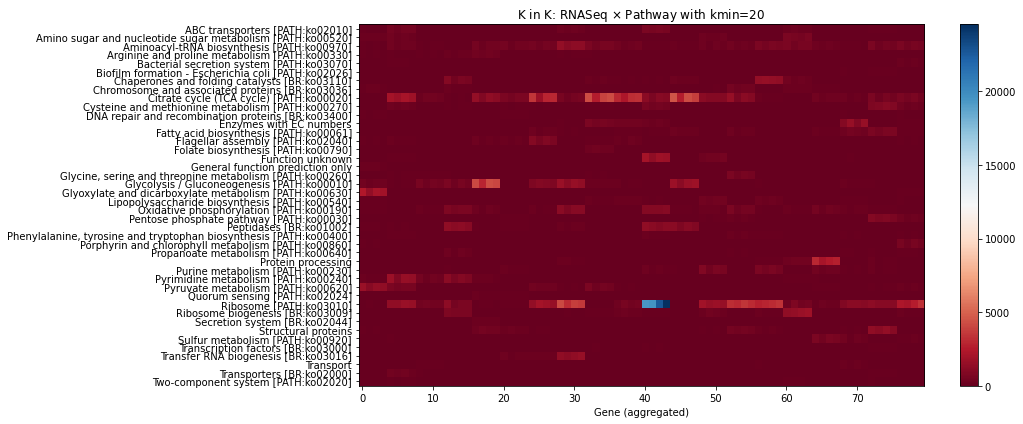

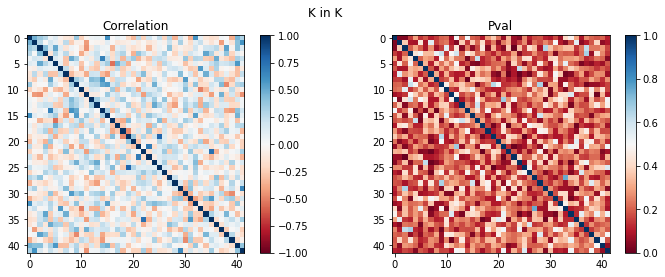

Critical thresh: 0.3501
Attained pvalue: 0.0100
Determined thresh: 0.4540


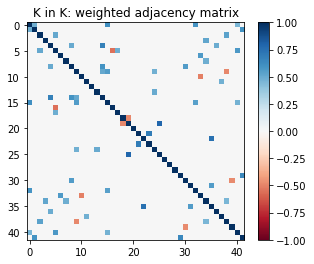

[ 0.47967841  0.61595819  0.59222007  0.45905547  0.60094191  0.51341946
  0.53451048  0.51659915  0.50660976  0.67609092  0.49247189 -0.55430619
  0.48683497  0.5742972   0.5677481   0.48922883  0.59834673  0.55794245
  0.51436418  0.56029223  0.47789978 -0.47699187 -0.50706482  0.4774546
  0.5002004   0.54426669  0.46973352 -0.47887437  0.79504124  0.70140515
  0.74933141  0.64299006 -0.47390371  0.55727874  0.45610022]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


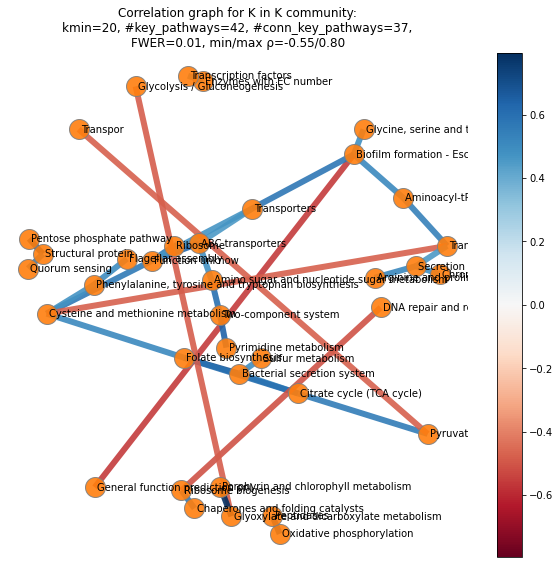

============ K in FK ============


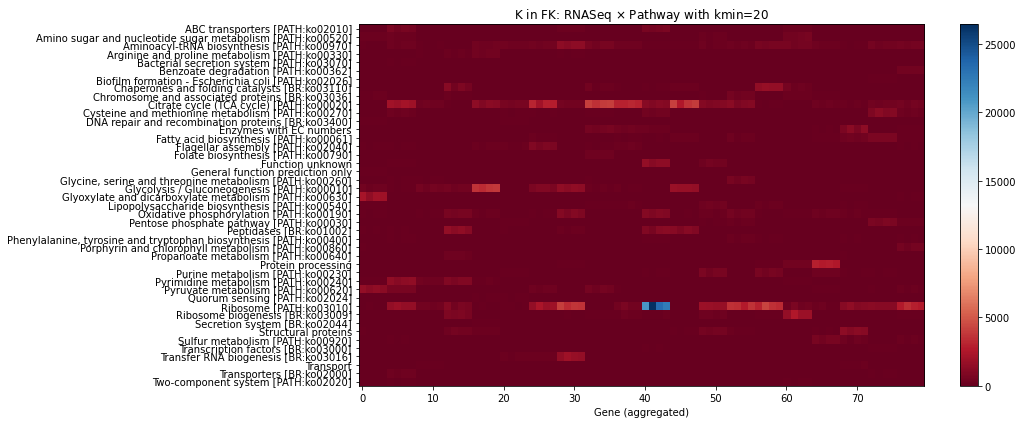

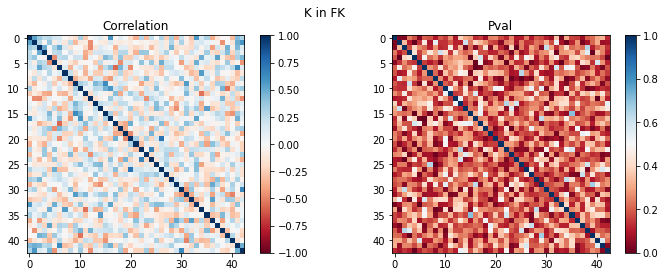

Critical thresh: 0.3509
Attained pvalue: 0.0100
Determined thresh: 0.4551


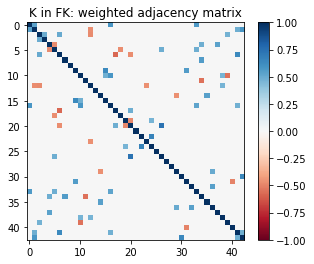

[ 0.53284854  0.58345019  0.56712324 -0.46204899  0.48846841  0.58342499
  0.49605521  0.50262587 -0.47386968  0.47494576 -0.47299002  0.49081371
  0.53152149 -0.4670251   0.48755513  0.48850438 -0.57031716 -0.46631946
  0.63802247  0.55662508  0.63430052  0.56135406  0.48146036  0.58156534
  0.46325828 -0.54351519 -0.54334578 -0.45591677  0.46587749 -0.4551837
  0.53925485  0.52534372  0.48105039  0.48989879 -0.4840555   0.46491978
  0.73713242  0.67168044  0.50559249  0.64746044 -0.49997234  0.54497457
  0.48452183]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


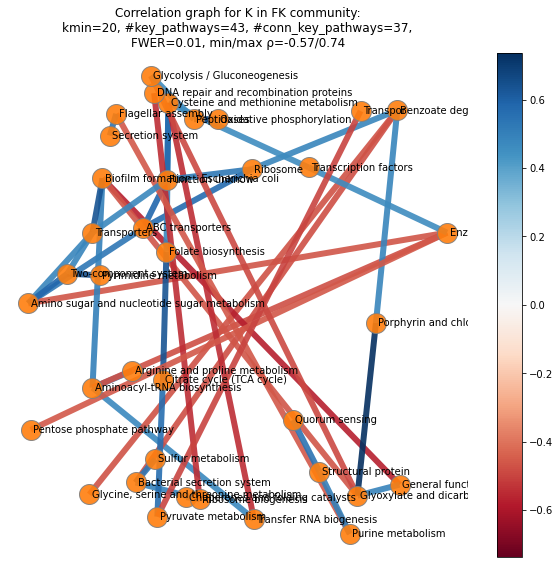

============ K in BK ============


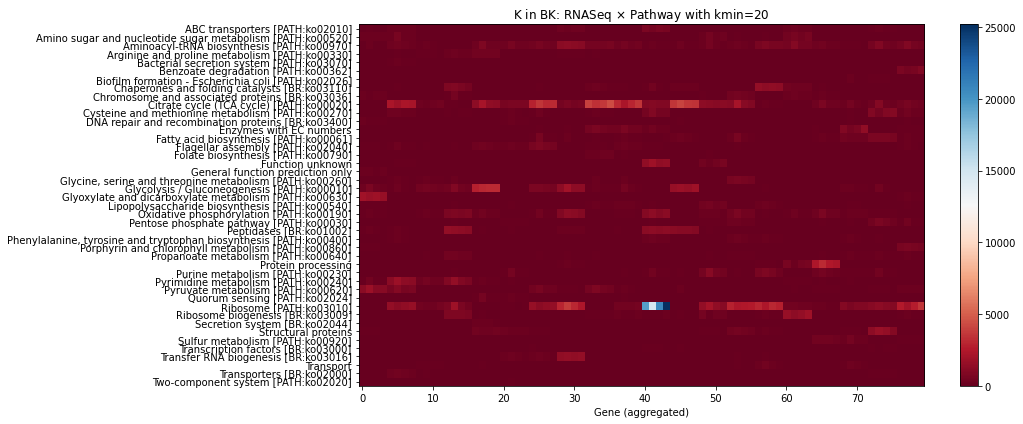

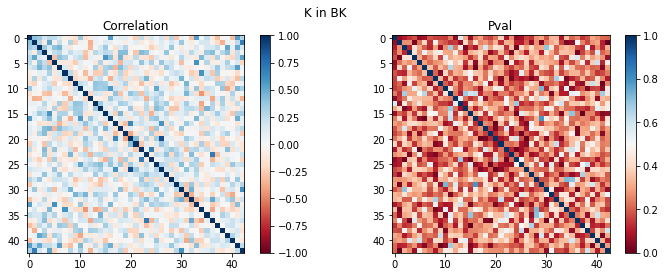

Critical thresh: 0.3509
Attained pvalue: 0.0100
Determined thresh: 0.4551


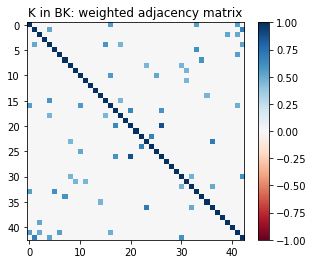

[0.55333105 0.54033092 0.54913491 0.50831483 0.6852253  0.52328654
 0.50446679 0.58160101 0.46794196 0.52775267 0.60405603 0.53906261
 0.60150454 0.45908726 0.46739825 0.46605689 0.56608013 0.50846752
 0.45667657 0.4679558  0.45881427 0.48965717 0.64079936 0.59296143
 0.8808219  0.67209704 0.70952465 0.47109506 0.60669673 0.50733503]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


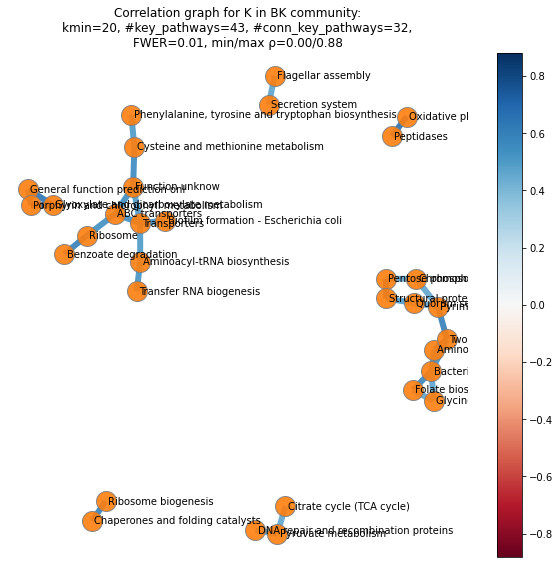

============ K in BFK ============


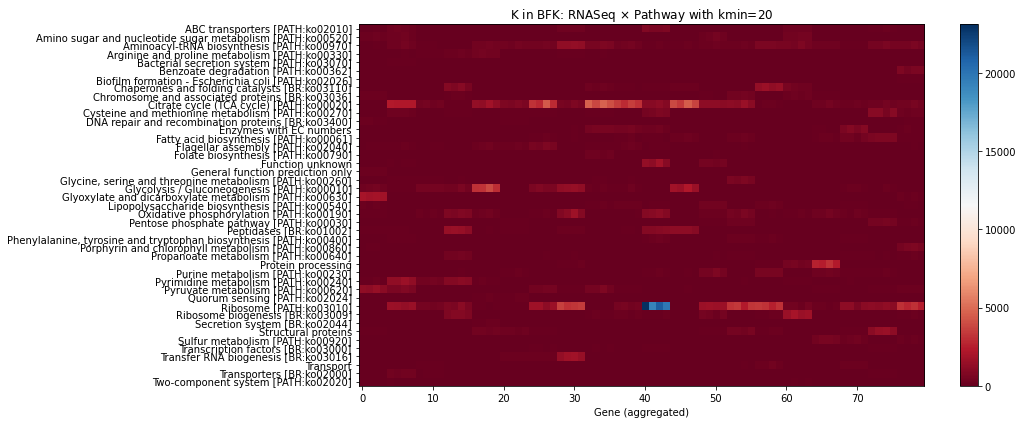

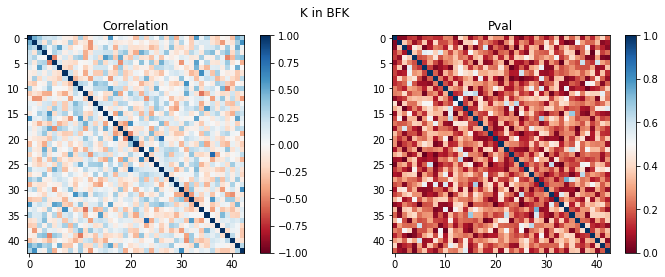

Critical thresh: 0.3509
Attained pvalue: 0.0100
Determined thresh: 0.4551


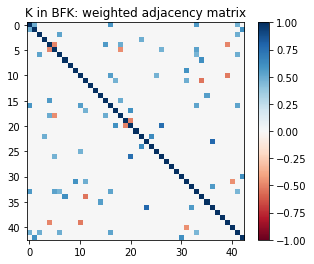

[ 0.48784497  0.58162494  0.56825196  0.48201546  0.60294017  0.52944175
  0.49130978  0.48642094 -0.48774874  0.56857778  0.49458974 -0.48878828
 -0.46190098  0.46895635  0.53641748  0.46701052  0.49069355  0.61258297
  0.59853441  0.55451959  0.47095994 -0.51933775  0.47326509  0.48566225
 -0.53619423  0.5517315   0.49224878  0.52839542  0.52354516  0.60598126
 -0.49992664  0.75381787  0.62709289  0.788044    0.61128237 -0.45634387
  0.56837948  0.45838973]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


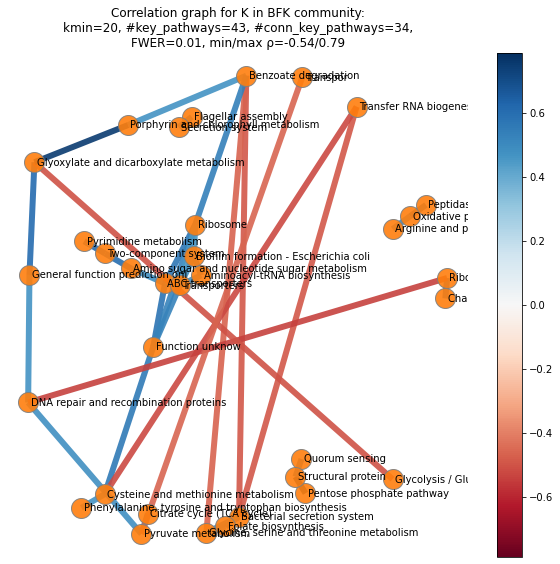

In [20]:
kmin = 20 # minimum genes in a pathway
N = 4 # number of replicates

for sp in ['K']: #SPECIES:
    lengths = pathways[sp].groupby('DescC').size()
    top_pathways = lengths[lengths >= kmin].index.sort_values()
    degrees = pd.DataFrame()
    conn_pathways = {}  # A dict mapping comm to connected pathway IDs
    for comm in COMMUNITIES:
        if sp not in comm:
            continue
        print("============ {} in {} ============".format(sp, comm))
        reps = [comm + str(i) for i in range(1,1+N)]
        degrees[comm] = run_analysis(sp, reps,
            kmin=kmin, par_corr=False, FWER=0.01, FWER_filter=False,
            run_sham=0)
        conn_pathways[comm] = set((degrees[comm] >= 0).to_numpy().nonzero()[0])

    if False:
        print(degrees)

    if False:
        fig, ax = plt.subplots(1, 2, figsize=(8,4))
        ax[0].set_title('Correlated pathways in {}'.format(sp))
        venn(conn_pathways, fmt="{enum}", fontsize=8, ax=ax[0])
        ax[1].invert_yaxis()
        ax[1].set_yticks(range(len(top_pathways)))
        ax[1].tick_params(axis='y', which='major', labelsize=6)
        for spine in ax[1].spines.values():
            spine.set_visible(False)
        ax[1].set_xticks([])
        for i, pathway in enumerate(top_pathways):
            ipdb.set_trace()
            ax[1].text(0.02, i, pathway, fontdict={'size': 6}, verticalalignment='center')
        plt.show()

* use absolute value as weights
* simulation: diag cov, check the expected # of nonzeros in adjacency matrix, check if it is close to the predicted #.